In [1]:
import cosy
print(cosy.read_sub_eval("./mergs.fox",{},use_gui=False)())

   1.018221      3.655208      0.000000      0.000000      0.000000     100000
  0.1006066E-01  1.018221      0.000000      0.000000      0.000000     010000
   0.000000      0.000000     0.9818891     -3.611208      0.000000     001000
   0.000000      0.000000     0.9939557E-02 0.9818891      0.000000     000100
   0.000000      0.000000      0.000000      0.000000      1.000000     000010
   0.000000      0.000000      0.000000      0.000000     0.9011952E-05 000001
   0.000000      0.000000      0.000000      0.000000    -0.2149501E-01 200000
   0.000000      0.000000      0.000000      0.000000    -0.1783493E-01 110000
   0.000000      0.000000      0.000000      0.000000    -0.4909064E-02 020000
   0.000000      0.000000      0.000000      0.000000    -0.2118489E-01 002000
   0.000000      0.000000      0.000000      0.000000     0.1740814E-01 001100
 -0.1772739E-01-0.2141704E-01  0.000000      0.000000      0.000000     100001
 -0.9817591E-02-0.1772739E-01  0.000000      0.00000

In [ ]:
import cosy

cosy.read_sub_eval("./mergs.fox", {} | cosy.INCLUDE_UTILS, use_gui=True)()

''

In [6]:
import cross_sections
import numpy as np
from physical_constants import MeV

cross_sections.calculate_pairproduction_cross_section(
    np.linspace(5, 20, 100) * MeV,
    np.linspace(0, 1, 200),
    np.linspace(0, np.pi/2, 250),
    np.linspace(0, np.pi/2, 250),
    np.linspace(0, np.pi * 2, 200),
)

[14:53:30]  gen pair-production cross-section:  0.0%  1.0s/6.1hr  ETA: 21:01:17 [T-6.1hr]
[14:53:31]  gen pair-production cross-section:  0.01%  2.5s/6.7hr  ETA: 21:33:36 [T-6.7hr]
[14:53:33]  gen pair-production cross-section:  0.02%  4.8s/6.6hr  ETA: 21:31:16 [T-6.6hr]
[14:53:37]  gen pair-production cross-section:  0.03%  8.1s/6.6hr  ETA: 21:29:27 [T-6.6hr]
[14:53:42]  gen pair-production cross-section:  0.06%  13.2s/6.5hr  ETA: 21:24:30 [T-6.5hr]
[14:53:49]  gen pair-production cross-section:  0.09%  20.8s/6.3hr  ETA: 21:10:35 [T-6.3hr]
[14:54:01]  gen pair-production cross-section:  0.15%  32.2s/6.2hr  ETA: 21:03:14 [T-6.2hr]
[14:54:18]  gen pair-production cross-section:  0.22%  49.3s/6.1hr  ETA: 20:58:27 [T-6.1hr]


KeyboardInterrupt: 

/usr/local/lib/python3.10/dist-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
/home/skylol/Desktop/school/U0/code/mer_prototype/util.py:88: RuntimeWarning: invalid value encountered in divide
  return np.transpose(x / x[-1], axes=axes)


------ si 0.25mm ------
pre-aperture efficiency: 0.001574912
post-aperture efficiency: 0.000719632  [1/1389.5991284434267]
electrons per megawatt: 13.56473216928
electrons @140MW: 1899.0625036991999


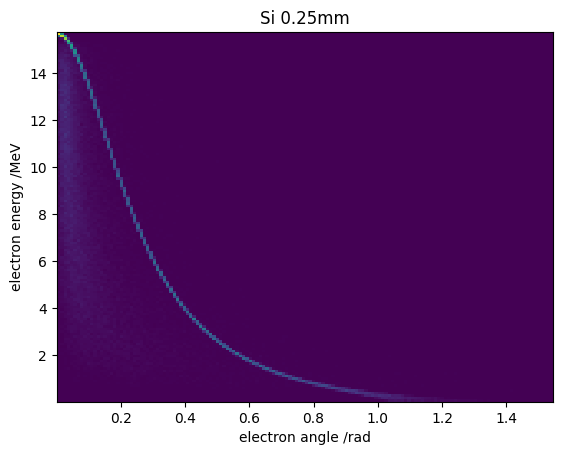

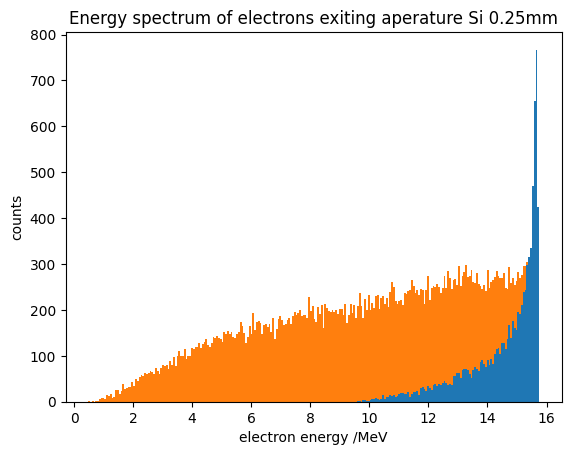

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from cross_sections import (
    gen_cross_section_compton,
    gen_cross_section_pairproduction,
    load_pairproduction_cross_section,
)
from acceptance import SRXMData, foil_trace, Foil, aperture
from physical_constants import mol, MeV, millimeter

R_FOIL = 0.02
R_APERTURE = 0.03
DIST_APERTURE = 0.25
x_depth_mm = 0.25
N_BY_Z = 1_000_000_000


Z = 16
N = N_BY_Z / Z
x_density = 2.329085  # [g/cm^3]
x_atomic_weight = 28.085  # [amu | g/mol]
material_name = "si"

x_number_density = x_density * 1e6 / x_atomic_weight * mol  # [/m^3]

with open(f"./_data/estar_{material_name}.txt", "r", encoding="utf8") as srem:
    x_srem = np.array(
        [[float(y) for y in x.split(" ")[:2]] for x in srem.readlines()[9:]]
    )
    x_srem[:, 0] *= MeV  #  MeV  ->  J
    x_srem[:, 1] *= x_density * 100 * MeV  #  MeV cm^2 / g  ->  J / m
    x_srem: SRXMData = x_srem[:, 0], x_srem[:, 1]

x_crosssection_compton = gen_cross_section_compton(
    x_number_density * Z,
    np.linspace(15, 17, 3) * MeV,
    np.linspace(0.0, np.pi, 1000),
)
x_crosssection_pairproduction = gen_cross_section_pairproduction(
    Z,
    x_number_density,
    load_pairproduction_cross_section("./_data/pairprod_xsctn_medium.npz"),
)
x_foil: Foil = x_srem, [
    x_crosssection_compton,
    x_crosssection_pairproduction,
]

elec_angle, elec_energy, ids = foil_trace(
    n_rays_incident=N,
    n_srxm_steps=100,
    phot_energy_in=16 * MeV,
    foil_properties=x_foil,
    foil_depth=x_depth_mm * millimeter,
)

print(f"------ {material_name} {x_depth_mm}mm ------")
print(f"pre-aperture efficiency: {elec_energy.size / N}")

foil_area = 3.14159 * (R_FOIL / 1e-2) ** 2
gamma_per_cm2_MW = 1.5e3

t, p, x, y, en, i = aperture(
    (elec_angle, elec_energy, ids), R_FOIL, R_APERTURE, DIST_APERTURE
)
print(f"post-aperture efficiency: {en.size / N}  [1/{N / en.size }]")
print(f"electrons per megawatt: {(en.size / N) * gamma_per_cm2_MW * foil_area}")
print(f"electrons @140MW: {(en.size / N) * gamma_per_cm2_MW * foil_area * 140}")

plt.hist2d(elec_angle, elec_energy / MeV, bins=150)
plt.title(f"{material_name[0].upper()}{material_name[1:]} {x_depth_mm}mm")
plt.xlabel("electron angle /rad")
plt.ylabel("electron energy /MeV")
plt.show()
plt.hist([en[i==0] / MeV,en[i==1] / MeV], bins=250, stacked=True)
plt.title(
    f"Energy spectrum of electrons exiting aperature {material_name[0].upper()}{material_name[1:]} {x_depth_mm}mm"
)
plt.xlabel("electron energy /MeV")
plt.ylabel("counts")
plt.show()

In [2]:
import acceptance

the = i == 0
input_rays = acceptance.rays_to_cosyscript(
    (t[the][:20], p[the][:20], x[the][:20], y[the][:20], en[the][:20], i[the][:20]), 16 * MeV
)
# acceptance.rays_into_relative((t, p, x, y, en, i), 16 * MeV).shape

import cosy

print(
    cosy.read_sub_eval(
        "./mergs.fox", {"input_rays": input_rays} | cosy.INCLUDE_UTILS, use_gui=True
    )()
)

In [ ]:
import cosy;
print(cosy.eval_fox(cosy.content_subs(
"""

{{INCLUDE_UTILS}}


PROCEDURE main;
    CONFIG_ORDER_AND_VARIABLES 5 3 0;
    CONFIG_AS_ELECTRON_BEAM 10;

    UNITY_MAP;
    ELT_DRIFT_LENGTH 0.5;

    WRITE_MAP 0;
ENDPROCEDURE;



""",cosy.INCLUDE_UTILS))())

   1.000000      0.000000      0.000000      0.000000      0.000000     100000
  0.5000000      1.000000      0.000000      0.000000      0.000000     010000
   0.000000      0.000000      1.000000      0.000000      0.000000     001000
   0.000000      0.000000     0.5000000      1.000000      0.000000     000100
   0.000000      0.000000      0.000000      0.000000      1.000000     000010
   0.000000      0.000000      0.000000      0.000000     0.1236783     000001
   0.000000      0.000000      0.000000      0.000000    -0.1256626     020000
 -0.2513252      0.000000      0.000000      0.000000      0.000000     010001
   0.000000      0.000000      0.000000      0.000000    -0.1256626     000200
   0.000000      0.000000    -0.2513252      0.000000      0.000000     000101
   0.000000      0.000000      0.000000      0.000000    -0.9325044E-01 000002
  0.2500000      0.000000      0.000000      0.000000      0.000000     030000
   0.000000      0.000000     0.2500000      0.00000

In [4]:
import cosy;
cosy.eval_fox(cosy.content_subs("""
PROCEDURE main;
WRITE 0 'HELLO';
ENDPROCEDURE;
""",{}))()

'HELLO\n'

In [6]:
from physical_constants import *
elec_rest_energy/MeV,16-elec_rest_energy/MeV

(0.5109914984396455, 15.489008501560354)